# Rainfall Forecasting Notebook


this notebook aims to forecast daily temperature as a supplematery data to eventually
predict crop yield prediction for Varuna. This notebook performs a 120-day average temperature forecast using the prophet machine learning model. The performance of the model can be seen in the testing section down below.

Dataset: retrieved from Nasa API as a .csv file. The source can also be obtained from Mr. Tranid, a senior GIS engineer at Varuna.
Dataset characteristics:
      1. 20 years Chaiyaphumi weather dataset
      2. Daily indexed aveerage temperature value
      3. training set: 2000-01-09 to 2020-08-10
  

Machine Learning Model:
      Neural Prophet


Author: Khanin Udomchoksakul ( Pao )
Team: Bedrock
Stakholder: Varuna
Date Initated: 8/2021 - 11/2021

Please keep in mind that the model needs to be retrained once data becomes available to update the seasonality and trend onto its weights.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
from datetime import datetime
date_format = "%Y-%m-%d"
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from pandas import DataFrame
from prophet import Prophet
from prophet.diagnostics import cross_validation
from pandas import read_csv
# normalize
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
#for testing stationary
from statsmodels.tsa.stattools import pacf

In [61]:
#helper functions

#set date as index
def set_date_index(data):
    data.set_index('DATE', inplace=True)
    print(data)
    data.columns


def train_test_split(data):
   
    start_date_test = pd.to_datetime('2019-10-30')
    end_date_test = pd.to_datetime('2021-08-10')
    
    start_date_test_str = start_date_test.strftime("%Y-%m-%d")
    end_date_test_str = end_date_test.strftime("%Y-%m-%d")
    data_test = data[start_date_test_str: end_date_test_str]

    start_date = pd.to_datetime('2000-01-02')
    end_date = pd.to_datetime('2019-10-29')
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    data = data[start_date_str: end_date_str]
    return data_test, data


def ps(ds):
    date = (pd.to_datetime(ds)).date()
    
    if df_train['PS'][date:].empty:
        return data_test['PS'][date:].values[0]
    else:
        return (df_train['PS'][date:]).values[0]
    
    return 0

def rh2m(ds):
    date = (pd.to_datetime(ds)).date()
    
    if df_train['RH2M'][date:].empty:
        return data_test['RH2M'][date:].values[0]
    else:
        return (df_train['RH2M'][date:]).values[0]
    
    
    return 0

# def create_lag_features(y):
   
#     scaler = StandardScaler()
#     features = pd.DataFrame()
    
#     partial = pd.Series(data=pacf(y, nlags=120))
#     lags = list(partial[np.abs(partial) >= 0.2].index)
    
#     df = pd.DataFrame()
    
#     # avoid to insert the time series itself
#     lags.remove(0)
    
#     for l in lags:
#         df[f"lag_{l}"] = y.shift(l)
    
#     features = pd.DataFrame(scaler.fit_transform(df[df.columns]),
#                             columns=df.columns)
#     features.index = y.index
    
#     return features
# temp_lag = create_lag_features(data["T2M"])

# Data Prepossesing

In [42]:
# read dsv data file

data = read_csv('forecasting_features.csv', header=0)
data.columns

Index(['DATE', 'T2M_MAX', 'T2M_MIN', 'T2M', 'PRECTOTCORR', 'TS_MAX', 'TS_MIN',
       'TS', 'RH2M', 'T2MDEW', 'PS', 'WS2M', 'ALLSKY_SFC_SW_DWN'],
      dtype='object')

In [43]:
data.tail()

,DATE,T2M_MAX,T2M_MIN,T2M,PRECTOTCORR,TS_MAX,TS_MIN,TS,RH2M,T2MDEW,PS,WS2M,ALLSKY_SFC_SW_DWN
7888,2021-08-06,28.62,22.55,25.41,10.55,29.44,22.19,25.40,89.94,23.58,96.63,2.48,5.90
7889,2021-08-07,28.55,23.02,25.62,0.00,29.20,22.66,25.59,91.12,24.01,96.69,2.66,6.52
7890,2021-08-08,28.78,23.86,25.83,5.27,29.08,23.50,25.73,92.62,24.51,96.65,2.27,6.58
7891,2021-08-09,29.23,23.83,26.23,5.27,29.77,23.51,26.17,92.06,24.80,96.53,2.20,6.51
7892,2021-08-10,28.46,24.39,26.12,5.27,28.73,24.02,25.98,92.81,24.83,96.42,1.70,5.67


In [44]:
date = data['DATE']
date = DataFrame(date) 
date

,DATE
0,2000-01-01
1,2000-01-02
2,2000-01-03
3,2000-01-04
4,2000-01-05
...,...
7888,2021-08-06
7889,2021-08-07
7890,2021-08-08
7891,2021-08-09


In [45]:
# drop irrelevant data 

data = data.drop(['T2M_MIN', 'RH2M', 'PS', 'RH2M', 'T2M_MAX','PRECTOTCORR', 'TS_MAX', 'TS_MIN', 'T2MDEW','TS', 'WS2M', 'ALLSKY_SFC_SW_DWN' ], axis=1)
set_date_index(data)
data

              T2M
DATE             
2000-01-01  22.16
2000-01-02  22.35
2000-01-03  22.94
2000-01-04  23.46
2000-01-05  25.03
...           ...
2021-08-06  25.41
2021-08-07  25.62
2021-08-08  25.83
2021-08-09  26.23
2021-08-10  26.12

[7893 rows x 1 columns]


,T2M
DATE,
2000-01-01,22.16
2000-01-02,22.35
2000-01-03,22.94
2000-01-04,23.46
2000-01-05,25.03
...,...
2021-08-06,25.41
2021-08-07,25.62
2021-08-08,25.83


In [46]:
# Experiments that do not include in real implementation

# nor_month = scaler.fit_transform(months)
# nor_month = DataFrame(nor_month)
# nor_month.rename(columns={0:'month'},inplace=True)

# data['month'] = months.iloc[:,0].values
# data

# is_NaN = temp_lag.isnull()
# row_has_NaN  = is_NaN.any(axis=1)
# rows_with_NaN = temp_lag[row_has_NaN ]

# print(rows_with_NaN)
# tem_lag = temp_lag[1:7893]
# temp_lag


# data['temp_lag'] = temp_lag.iloc[:,0].values
# data

# scaler = MinMaxScaler()
# nor_temp_lag = scaler.fit_transform(temp_lag)
# nor_temp_lag = DataFrame(temp_lag)
# nor_temp_lag.rename(columns={0:'temp_lag'},inplace=True)


# nor_rh2m = scaler.fit_transform(data_rh2m)
# nor_rh2m = DataFrame(nor_rh2m)
# nor_rh2m.rename(columns={0:'RH2M'},inplace=True)


# nor_ps = scaler.fit_transform(data_ps)
# nor_ps = DataFrame(nor_ps)
# nor_ps.rename(columns={0:'PS'},inplace=True)

# data['RH2M'] = nor_rh2m.iloc[:,0].values

#data['PS'] = nor_ps.iloc[:,0].values

In [47]:
#no differencing
#Train test split training and testing data
data_test, data = train_test_split(data)

In [48]:
#Set date index to 'ds' column to match prophet format

data['ds'] = data.index

/tmp/ipykernel_59597/1416003694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ds'] = data.index


In [51]:
data_test

,T2M
DATE,
2019-10-30,22.23
2019-10-31,21.90
2019-11-01,22.39
2019-11-02,24.44
2019-11-03,24.82
...,...
2021-08-06,25.41
2021-08-07,25.62
2021-08-08,25.83


In [52]:
# rename rain to y to match prophet format
data.rename(columns={'T2M':'y'},inplace=True)
data

/home/kudomcho/.local/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,y,ds
DATE,,
2000-01-02,22.35,2000-01-02
2000-01-03,22.94,2000-01-03
2000-01-04,23.46,2000-01-04
2000-01-05,25.03,2000-01-05
2000-01-06,26.15,2000-01-06
...,...,...
2019-10-25,25.45,2019-10-25
2019-10-26,25.91,2019-10-26
2019-10-27,26.05,2019-10-27


<AxesSubplot:xlabel='ds'>

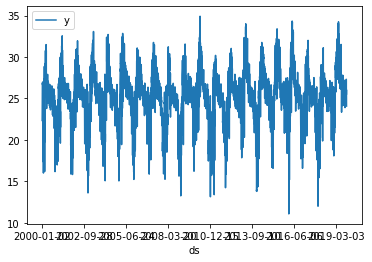

In [53]:
data.plot('ds', 'y')

In [54]:
#check data dimension and column names

print(data.shape)
print(data.columns)

(7241, 2)
Index(['y', 'ds'], dtype='object')


In [55]:
#create a df_train dataframe for training ( not necessary )
df_train = data[['ds', 'y']]
df_train


,ds,y
DATE,,
2000-01-02,2000-01-02,22.35
2000-01-03,2000-01-03,22.94
2000-01-04,2000-01-04,23.46
2000-01-05,2000-01-05,25.03
2000-01-06,2000-01-06,26.15
...,...,...
2019-10-25,2019-10-25,25.45
2019-10-26,2019-10-26,25.91
2019-10-27,2019-10-27,26.05


In [56]:
#differencing
#set date as index
# data.set_index('DATE', inplace=True)
# print(data)
# data_diff = data

# data_diff = data.diff(periods=1)
# data_diff.plot()
# data_diff['ds'] = data_diff.index
# data_diff.columns
# data_diff.rename(columns={'ds':'ds','MAXIMUM TEMPERATURE':'y'},inplace=True)
# data.shape
# data_diff.head()
# data_diff.dropna(subset=['y'], inplace=True)
# df_train = data_diff[['ds', 'y']]
# df_train

In [57]:
# get prophet model
m = Prophet()



In [58]:
# train with training data
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -45.0883
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16960.9      0.022627       225.306           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       16977.6    0.00379449       291.285      0.5029      0.5029      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16984.1     0.0231902       491.286      0.2378           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       16984.2   8.83844e-05       287.688   2.097e-07       0.001      407  LS failed, Hessian reset 
     399       16988.7    0.00032993       141.952           1           1      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       16989.9    0.00386085    

In [59]:
# make an empty dataframe 120 days further from the most current data from training data

futures = m.make_future_dataframe(periods=120)
futures

,ds
0,2000-01-02
1,2000-01-03
2,2000-01-04
3,2000-01-05
4,2000-01-06
...,...
7356,2020-02-22
7357,2020-02-23
7358,2020-02-24
7359,2020-02-25


In [39]:
#No longer needed but useful ones for multiregressor

# future_range = pd.date_range('2019-10-30', periods=120, freq='D')
# future_ps_df = pd.DataFrame({ 'future_date': future_range, 'future_ps' : 0})
# future_ps_df

# future_rh2m_df = pd.DataFrame({ 'future_date': future_range, 'future_rh2m' : 0})
# future_rh2m_df

# future_ps_df['future_date'] = pd.to_datetime(future_ps_df['future_date'])
# future_ps_df = future_ps_df.set_index('future_date')

# future_rh2m_df['future_date'] = pd.to_datetime(future_rh2m_df['future_date'])
# future_rh2m_df = future_rh2m_df.set_index('future_date')
# future_rh2m_df.head()


# future_range = pd.date_range('2020-08-02', periods=120, freq='D')
# future_month_df = pd.DataFrame({ 'future_date': future_range, 'future_month' : 0})
# future_month_df
# future_month_df['future_date'] = pd.to_datetime(future_month_df['future_date'])
# future_month_df = future_month_df.set_index('future_date')

# def month(ds):
#     date = (pd.to_datetime(ds)).date()
    
#     if df_train['month'][date:].empty:
#         return data_test['month'][date:].values[0]
#     else:
#         return (df_train['month'][date:]).values[0]
    
    
#     return 0

# futures['month'] = futures['ds'].apply(month)


# future_month_df = pd.DataFrame({ 'future_date': future_range, 'future_month' : 0})
# future_month_df
# future_month_df['future_date'] = pd.to_datetime(future_month_df['future_date'])
# future_month_df = future_month_df.set_index('future_date')


# future_temp_lag_df = pd.DataFrame({ 'future_date': future_range, 'future_temp_lag' : 0})
# future_temp_lag_df
# future_temp_lag_df['future_date'] = pd.to_datetime(future_temp_lag_df['future_date'])
# future_temp_lag_df = future_temp_lag_df.set_index('future_date')

# def temp_lag(ds):
#     date = (pd.to_datetime(ds)).date()
    
#     if df_train['temp_lag'][date:].empty:
#         return data_test['temp_lag'][date:].values[0]
#     else:
#         return (df_train['temp_lag'][date:]).values[0]
    
    
#     return 0

# futures['temp_lag'] = futures['ds'].apply(temp_lag)



In [60]:
# check test data

data_test

,T2M
DATE,
2019-10-30,22.23
2019-10-31,21.90
2019-11-01,22.39
2019-11-02,24.44
2019-11-03,24.82
...,...
2021-08-06,25.41
2021-08-07,25.62
2021-08-08,25.83


In [63]:
# predict on the training data and forecast date 

forecast = m.predict(futures)


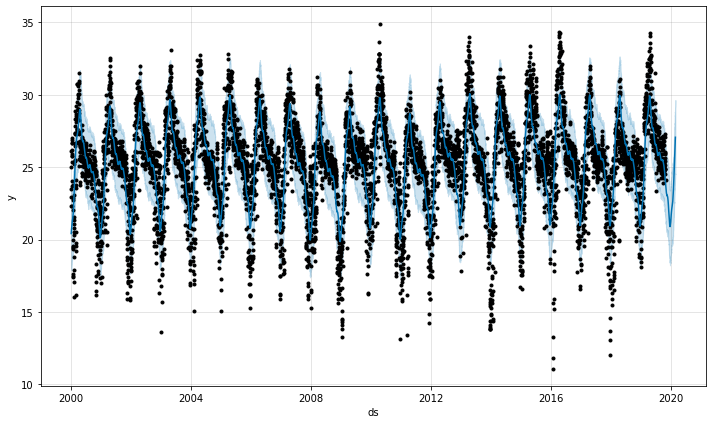

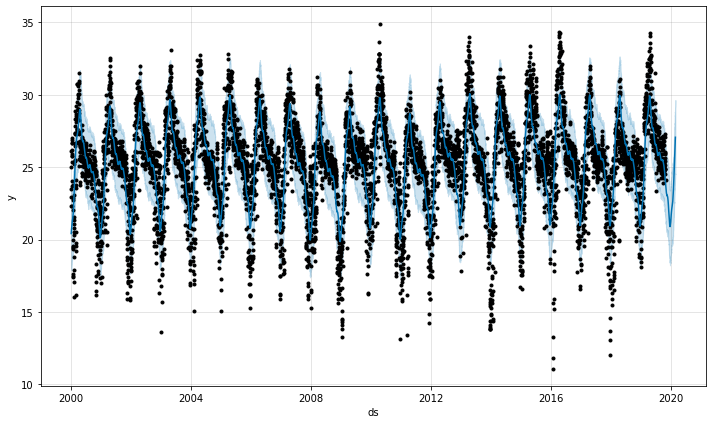

In [64]:
m.plot(forecast)

In [65]:
# check forecasted value from forecast dataframe

forecast[7241:7362]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7241,2019-10-30,25.587942,21.230222,26.439104,25.587942,25.587942,-1.797607,-1.797607,-1.797607,0.003247,0.003247,0.003247,-1.800855,-1.800855,-1.800855,0.0,0.0,0.0,23.790335
7242,2019-10-31,25.587864,21.188372,26.456139,25.587864,25.587864,-1.856689,-1.856689,-1.856689,0.017073,0.017073,0.017073,-1.873763,-1.873763,-1.873763,0.0,0.0,0.0,23.731175
7243,2019-11-01,25.587787,21.253895,26.072735,25.587787,25.587787,-1.958938,-1.958938,-1.958938,-0.014389,-0.014389,-0.014389,-1.944549,-1.944549,-1.944549,0.0,0.0,0.0,23.628849
7244,2019-11-02,25.587709,21.052437,26.083013,25.587709,25.587709,-2.019092,-2.019092,-2.019092,-0.006424,-0.006424,-0.006424,-2.012668,-2.012668,-2.012668,0.0,0.0,0.0,23.568617
7245,2019-11-03,25.587631,20.824663,25.998063,25.587631,25.587631,-2.063990,-2.063990,-2.063990,0.013611,0.013611,0.013611,-2.077601,-2.077601,-2.077601,0.0,0.0,0.0,23.523641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7356,2020-02-22,25.579009,24.114296,29.151115,25.558015,25.599304,0.981220,0.981220,0.981220,-0.006424,-0.006424,-0.006424,0.987645,0.987645,0.987645,0.0,0.0,0.0,26.560229
7357,2020-02-23,25.578931,24.193028,29.152299,25.557593,25.599994,1.135864,1.135864,1.135864,0.013611,0.013611,0.013611,1.122253,1.122253,1.122253,0.0,0.0,0.0,26.714795
7358,2020-02-24,25.578854,24.204198,29.226671,25.557231,25.600587,1.254434,1.254434,1.254434,0.004303,0.004303,0.004303,1.250131,1.250131,1.250131,0.0,0.0,0.0,26.833287
7359,2020-02-25,25.578776,24.562827,29.454138,25.556857,25.601309,1.353671,1.353671,1.353671,-0.017421,-0.017421,-0.017421,1.371093,1.371093,1.371093,0.0,0.0,0.0,26.932447


# Testing Section

# 30-10-2019 to 25/2/2020 forecast testing

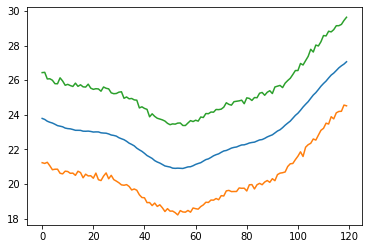

In [66]:
#plotting forecasted values

forecast_test = forecast[7241:7362][['yhat']]
forecast_test_lower = forecast[7241:7362][['yhat_lower']]
forecast_test_upper = forecast[7241:7362][['yhat_upper']]

pyplot.plot(forecast_test.values, label = 'predicted values')
pyplot.plot(forecast_test_lower.values, label = 'lower predicted values')
pyplot.plot(forecast_test_upper.values, label = 'upper predicted values')

[22.23 21.9  22.39 24.44 24.82 24.68 24.53 24.96 24.12 23.91 22.64 22.3
 22.22 24.4  24.18 24.15 23.08 25.23 26.94 25.9  24.69 23.77 23.76 23.26
 23.05 23.29 23.5  23.84 25.75 25.22 23.59 24.62 25.12 22.65 18.92 18.15
 17.45 15.87 15.52 16.29 16.87 17.38 18.11 19.76 21.28 22.28 23.44 23.94
 25.45 25.33 25.74 25.65 25.12 25.12 25.58 25.54 26.23 26.07 23.87 21.98
 22.8  23.6  24.46 24.37 24.65 24.56 24.99 24.42 24.46 24.73 25.22 25.3
 25.4  26.3  26.17 25.16 25.58 25.62 26.22 25.77 25.3  25.19 25.08 25.78
 27.23 28.6  29.44 28.51 27.31 24.26 24.36 23.36 21.43 21.62 23.38 24.71
 26.16 27.52 26.67 27.38 28.5  26.47 25.75 24.61 26.9  28.4  29.3  28.98
 27.74 27.11 24.53 22.74 24.15 25.22 25.08 24.51 24.69 25.01 25.84 26.49
 26.78]


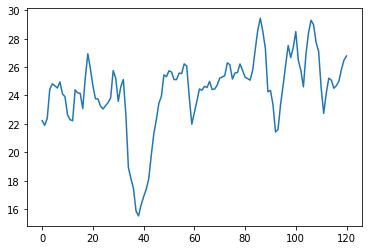

In [67]:
data_test_1=data_test['T2M'][0:121].values

print(data_test_1)
pyplot.plot(data_test_1, label = 'actual values')

In [68]:

diff_list = []
diff_accepted =[]
diff_rejected = []
count_rejected = 0
count_accepted = 0
for idx, yhat in enumerate(forecast_test.values):
    
    diff = yhat-data_test_1[idx]
   
    if diff>3 or diff<-3:
        diff_rejected.append(diff)
        count_rejected +=1
        print('day {} failed'.format(idx))
        
    else:
        diff_accepted.append(diff)
        count_accepted +=1
            
print(count_rejected)
print(count_accepted)

day 18 failed
day 34 failed
day 35 failed
day 36 failed
day 37 failed
day 38 failed
day 39 failed
day 40 failed
day 41 failed
day 42 failed
day 48 failed
day 49 failed
day 50 failed
day 51 failed
day 52 failed
day 53 failed
day 54 failed
day 55 failed
day 56 failed
day 57 failed
day 62 failed
day 63 failed
day 64 failed
day 65 failed
day 66 failed
day 70 failed
day 71 failed
day 72 failed
day 73 failed
day 74 failed
day 75 failed
day 76 failed
day 77 failed
day 78 failed
day 79 failed
day 83 failed
day 84 failed
day 85 failed
day 86 failed
day 87 failed
day 88 failed
day 97 failed
day 99 failed
day 100 failed
day 105 failed
day 106 failed
day 107 failed
day 111 failed
48
72


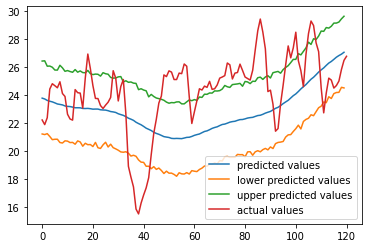

In [69]:

pyplot.plot(forecast_test.values, label = 'predicted values')
pyplot.plot(forecast_test_lower.values, label = 'lower predicted values')
pyplot.plot(forecast_test_upper.values, label = 'upper predicted values')
pyplot.plot(data_test_1, label = 'actual values')
pyplot.legend()

# 2020/02/26 - 2020/06/24 forecasting (2nd)

In [78]:

def predict_sample(first_date_idx, second_date_idx):
    second_test = date[first_date_idx:second_date_idx]
    second_test = second_test.rename(columns={'DATE':'ds'})
    print(second_test)
    second_forecast = m.predict(second_test)
    #m.plot(second_forecast)
    print(second_forecast)

    return second_forecast

In [90]:
def test_sample(second_forecast, first_test_date_idx, second_test_date_idx):
    second_forecast_test = second_forecast[0:119][['yhat']]
    second_forecast_test_lower = second_forecast[0:119][['yhat_lower']]
    second_forecast_test_upper = second_forecast[0:119][['yhat_upper']]
    #print(second_forecast_test.values)


    data_test_2=data_test['T2M'][first_test_date_idx:second_test_date_idx].values

    #print(data_test_2)
    

    diff_list_2 = []
    diff_accepted_2 =[]
    diff_rejected_2 = []
    count_rejected_2 = 0
    count_accepted_2 = 0
    for idx, yhat in enumerate(second_forecast_test.values):

        diff = yhat-data_test_2[idx]

        if diff>3 or diff<-3:
            diff_rejected_2.append(diff)
            count_rejected_2 +=1
            print('day {} failed'.format(idx))

        else:
            diff_accepted_2.append(diff)
            count_accepted_2 +=1

    print(count_rejected_2)
    print(count_accepted_2)
    
    pyplot.plot(second_forecast_test_upper.values, label = 'upper predicted values')
    pyplot.plot(second_forecast_test.values, label = 'predicted values')
    pyplot.plot(second_forecast_test_lower.values, label = 'lower predicted values')
    pyplot.plot(data_test_2, label = 'actual values')
    pyplot.legend()

In [92]:
second_forecast = predict_sample(7361, 7481)

              ds
7361  2020-02-26
7362  2020-02-27
7363  2020-02-28
7364  2020-02-29
7365  2020-03-01
...          ...
7476  2020-06-20
7477  2020-06-21
7478  2020-06-22
7479  2020-06-23
7480  2020-06-24

[120 rows x 1 columns]
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2020-02-26  25.578698   24.280581   29.598436    25.555028    25.601226   
1   2020-02-27  25.578621   24.674350   29.655073    25.554076    25.601739   
2   2020-02-28  25.578543   24.598699   29.800894    25.553999    25.602148   
3   2020-02-29  25.578465   24.716180   29.784739    25.552880    25.602477   
4   2020-03-01  25.578388   24.987101   29.912667    25.551845    25.602781   
..         ...        ...         ...         ...          ...          ...   
115 2020-06-20  25.569765   24.240751   29.177525    25.441170    25.669163   
116 2020-06-21  25.569688   24.138410   29.242841    25.440389    25.669647   
117 2020-06-22  25.569610   24.263347   29.338630    25.43837

day 8 failed
day 16 failed
day 17 failed
day 34 failed
day 35 failed
day 36 failed
day 47 failed
day 48 failed
day 50 failed
day 51 failed
day 52 failed
day 57 failed
day 58 failed
day 59 failed
day 60 failed
day 61 failed
16
103


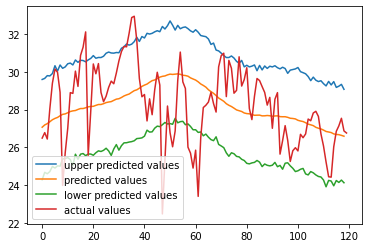

In [93]:
test_sample(second_forecast, 119, 239)

# 2020/06/25 - 2020/10/22 forecasting (3rd)

In [94]:
third_forecast = predict_sample(7481, 7601)

              ds
7481  2020-06-25
7482  2020-06-26
7483  2020-06-27
7484  2020-06-28
7485  2020-06-29
...          ...
7596  2020-10-18
7597  2020-10-19
7598  2020-10-20
7599  2020-10-21
7600  2020-10-22

[120 rows x 1 columns]
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2020-06-25  25.569377   24.123345   29.028871    25.451734    25.688220   
1   2020-06-26  25.569299   23.840310   28.984287    25.450648    25.689698   
2   2020-06-27  25.569222   24.047898   29.115652    25.450063    25.690290   
3   2020-06-28  25.569144   23.974799   29.130067    25.448848    25.690707   
4   2020-06-29  25.569066   23.947442   29.080269    25.449158    25.692629   
..         ...        ...         ...         ...          ...          ...   
115 2020-10-18  25.560444   22.072558   26.959253    25.312772    25.831972   
116 2020-10-19  25.560366   21.912412   27.083562    25.310198    25.832396   
117 2020-10-20  25.560289   21.939360   27.029485    25.30762

day 104 failed
day 106 failed
day 114 failed
day 115 failed
day 116 failed
5
114


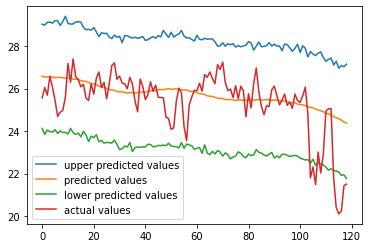

In [95]:
test_sample(third_forecast, 240, 359)

# 2021-02-27 - 2021-6-26 forecasting (4th)

              ds
7728  2021-02-27
7729  2021-02-28
7730  2021-03-01
7731  2021-03-02
7732  2021-03-03
...          ...
7843  2021-06-22
7844  2021-06-23
7845  2021-06-24
7846  2021-06-25
7847  2021-06-26

[120 rows x 1 columns]
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2021-02-27  25.550191   24.266717   29.758888    25.053155    26.080558   
1   2021-02-28  25.550113   24.655418   30.045047    25.050986    26.082242   
2   2021-03-01  25.550035   24.803217   30.148467    25.048817    26.083926   
3   2021-03-02  25.549958   24.979486   30.078507    25.046648    26.085610   
4   2021-03-03  25.549880   24.823201   30.190512    25.044479    26.087294   
..         ...        ...         ...         ...          ...          ...   
115 2021-06-22  25.541258   24.033085   29.623654    24.859106    26.287689   
116 2021-06-23  25.541180   23.827106   29.211309    24.857100    26.289371   
117 2021-06-24  25.541102   23.878092   29.380087    24.85259

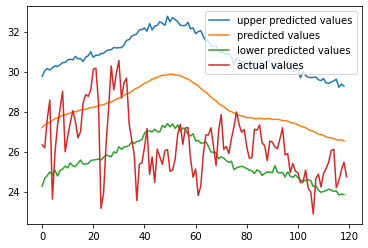

In [98]:
forth_forecast = predict_sample(7728, 7848)
test_sample(forth_forecast, 486, 606)

In [99]:
#No longer needed but useful

# forth_future_range = pd.date_range('2020-10-23', periods=120, freq='D')
# forth_future_ps_df = pd.DataFrame({ 'future_date': future_range, 'future_ps' : 0})
# forth_future_ps_df
# forth_future_ps_df['future_date'] = pd.to_datetime(forth_future_ps_df['future_date'])
# forth_future_ps_df = forth_future_ps_df.set_index('future_date')
# forth_test['PS'] = forth_test['ds'].apply(ps)

# forth_future_rh2m_df = pd.DataFrame({ 'future_date': future_range, 'future_rh2m' : 0})
# forth_future_rh2m_df
# forth_future_rh2m_df['future_date'] = pd.to_datetime(forth_future_rh2m_df['future_date'])
# forth_future_rh2m_df = forth_future_rh2m_df.set_index('future_date')
# forth_test['RH2M'] = forth_test['ds'].apply(rh2m)

In [318]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [100]:
from ipywidgets import FloatProgress

# Cross Validation

In [103]:
# specify the training days ( 7000 days ) , horizon ( forecasting range), and period ( typically period/2 ) and 
# the model will make the cutoff to forecast without data leakage
df_cv = cross_validation(m, initial='7000 days', period='60 days', horizon = '120 days')


INFO:prophet:Making 3 forecasts with cutoffs between 2019-03-03 00:00:00 and 2019-07-01 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

Initial log joint probability = -45.9115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16352.2    0.00159598       355.726      0.3295           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       16371.1     0.0155164       304.727           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16376.1     0.0104775        529.14           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       16377.3   0.000349005       571.352   8.921e-07       0.001      413  LS failed, Hessian reset 
     399       16379.2   7.67794e-05       92.3187      0.5953      0.5953      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     494       16379.9   4.63829e-05    

In [102]:
from prophet.diagnostics import performance_metrics

# shows that with each horizon, the model can reduce cumulative loss at each value 
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,2.569561,1.602985,1.317495,0.046506,0.035895,0.047186,0.833333
1,13 days,2.200013,1.483244,1.198995,0.042633,0.033672,0.043137,0.888889
2,14 days,2.135078,1.461191,1.158626,0.040430,0.033672,0.041279,0.916667
3,15 days,2.475693,1.573433,1.178802,0.040408,0.032830,0.041625,0.888889
4,16 days,2.768165,1.663780,1.271045,0.043373,0.035895,0.044793,0.861111
...,...,...,...,...,...,...,...,...
104,116 days,2.603628,1.613576,1.137024,0.041161,0.030336,0.042789,0.861111
105,117 days,2.715742,1.647951,1.188524,0.043175,0.031953,0.044877,0.861111
106,118 days,2.840575,1.685401,1.238446,0.045076,0.033360,0.046875,0.861111
107,119 days,2.981213,1.726619,1.313600,0.047899,0.034505,0.049800,0.861111


In [31]:
import json
from prophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model